# SARSA(lambda)

In [1]:
# Find the value function of policy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# display output
import random
from random import uniform
import time
from IPython.display import display, clear_output

In [2]:
actions = [[-1, 0], [0, 1], [1, 0], [0, -1]] #up, right, down, left = (clockwise from up) 
action_count = len(actions) # total number of actions
gridSize = 5 # create a square grid of gridSize by gridSize
state_count = gridSize*gridSize # total number of states

In [3]:
class Gridworld():
    def __init__(self, gridSize):
        self.valueMap = np.zeros((gridSize, gridSize))
        self.states = [[i, j] for i in range(gridSize) for j in range(gridSize)]
        self.size = gridSize
        self.new_pos = [0, 0] # initialize new position for p_transition
        self.transition_prob = 1 # deterministic
    
    def initial_state(self):        # return initial state
        return grid.states[gridSize*gridSize-1]
   
    def transition_reward(self, current_pos, action): # return the transition probability

        # get next position: state: [0, 0], action: [0, 1], new_state = [0, 1]
        self.new_pos = np.array(current_pos) + np.array(action)

        # normally, reward = 0
        reward = 0

        # if new pos results in off the grid, return reward -1
        if -1 in self.new_pos or self.size in self.new_pos:
            reward = -1
        # if in state A, receive + 10
        if current_pos == [0, 1]:
            reward = 10
        # if in state B, receive + 5
        if current_pos == [0, 3]:
            reward = 5

        # if taking an action crosses the border; agent's new_pos is the same as the current pos
        if -1 in self.new_pos or self.size in self.new_pos: 
            self.new_pos = current_pos
            
        # if in state A, transition to state A'
        if current_pos == [0, 1]:
            self.new_pos = [4, 1]
            
        # if in state B, transition to state B'
        if current_pos == [0, 3]:
            self.new_pos = [2, 3]

        return self.new_pos, reward

## Define Functions 

In [4]:
def choose_action(state, epsilon):
    
    # choose an action type: explore or exploit
    action_type = int(np.random.choice(2, 1, p=[epsilon,1-epsilon]))

    # find best action based on Q values
    best_action_index = np.argmax(Q_values[state])

    # pick a random action
    random_action_index = random.choice(range(4))

    # choose an action based on exploit or explore
    if action_type == 0:
        
        # while random action is the same as the best action, pick a new action
        while random_action_index == best_action_index:
            random_action_index = random.choice(range(4))
        
        # explore
        # print("explore")
        action_index = random_action_index
    else:
        # exploit
        # print("exploit")
        action_index = best_action_index
        
    return action_index

In [5]:
# define average function
def Average(lst): 
    return sum(lst) / len(lst) 

In [6]:
def generate_episode(steps):

    # set initial state
    state_vector = grid.initial_state()

    # initialize state (with iniitial state), action list and reward list
    state_list = [state_vector]
    action_list = []
    reward_list = []

    # generate an episode
    for i in range(steps):

        # pick an action based on categorical distribution in policy
        action_index = int(np.random.choice(action_count, 1, p=policy[grid.states.index(state_vector)])) 
        action_vector = actions[action_index] # convert the integer index (ie. 0) to action (ie. [-1, 0])

        # get new state and reward after taking action from current state
        new_state_vector, reward = grid.transition_reward(state_vector, action_vector)
        state_vector = list(new_state_vector)

        # save state, action chosen and reward to list
        state_list.append(state_vector)
        action_list.append(action_vector)
        reward_list.append(reward)
        
    return state_list, action_list, reward_list

## Sarsa(lambda) 

In [7]:
# initialize q values for all state action pairs
Q_values = np.zeros((state_count, action_count))

# create a grid object
grid = Gridworld(5)

# intialize parameters
gamma = 0.99
epsilon = 0.1
lamda = 0.9
lr = 0.1

# initialize list for plots
average_reward_list = []
cumulative_reward_list = []
cumulative_reward = 0
delta_list = []
episode_test_reward_list=[]

In [8]:
# iteration 500 times
for iteration in range(500):
    
    # initialize delta for eligibility trace
    delta_ = 0
    
    # delta for change in Q values
    delta = 0
    
    # initialize S,A (? should i choose an Action using epsilon-greedy here or just select an Action?)
    state_vector = grid.initial_state()
    state_index = grid.states.index(state_vector)
    
    # initialize  eligibility traces for all state action pairs of all states to 0
    z_values = np.zeros((state_count, action_count))
    
    action_index = choose_action(state_index, epsilon)
    action_vector = actions[action_index]
    
    reward_list = []
    
    # iteration 200 steps of the episode
    for i in range(200):

        # Take action A, oberserve R, S'
        next_state_vector, reward = grid.transition_reward(state_vector, action_vector)
        next_state_index = grid.states.index(list(next_state_vector))
        
        reward_list.append(reward)

        # Choose A' from S' using policy derived from Q (eg. epsilon-greedy)
        next_action_index = choose_action(next_state_index, epsilon)
        next_action_vector = actions[next_action_index]

        # update the action-value form of the TD error
        delta_ = reward + gamma*Q_values[next_state_index][next_action_index] - Q_values[state_index][action_index]
        
        # accumulate traces (? big S and big A?)
        z_values[state_index][action_index] +=1
        
        # calculate max Q_value change for plotting max delta
        Q_value = Q_values[state_index][action_index] + lr*delta_*z_values[state_index][action_index]
        delta = max(delta, np.abs(Q_value - Q_values[state_index][action_index]))   
        
        # update Q value
        Q_values[state_index][action_index] = Q_values[state_index][action_index] + lr*delta_*z_values[state_index][action_index]
        
        # update z value
        z_values[state_index][action_index] = gamma*lamda*z_values[state_index][action_index]
        
        # update state and action vector
        state_vector = list(next_state_vector)
        state_index = grid.states.index(state_vector)
        action_vector = list(next_action_vector)
        action_index = next_action_index
    
    # append delta
    delta_list.append(delta)
    
    # append average rewards
    average_reward_list.append(Average(reward_list))
    
    # append cumulative rewards
    cumulative_reward = cumulative_reward + sum(reward_list)
    cumulative_reward_list.append(cumulative_reward)
    
    # initialize q values for all state action pairs
    policy = np.zeros((state_count, action_count))
    
    # Generate Greedy policy based on Q_values after each episode
    for state in range(len(Q_values)):
        # find the best action at each state
        best_action = np.argmax(Q_values[state])
        # write deterministic policy based on Q_values
        policy[state][best_action] = 1
    
    # Generate test trajectory with the greedy policy
    state_list, action_list, test_reward_list = generate_episode(200)
    
    # sum up all the rewards obtained during test trajectory and append to list
    episode_test_reward_list.append(sum(test_reward_list))

## Plots 

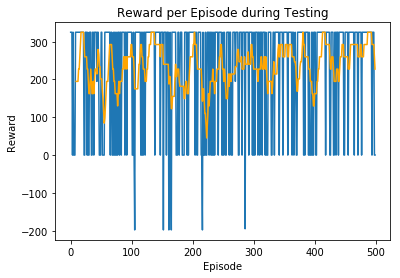

In [9]:
# test reward of each episode, where delta is the change in Q values
plt.plot(episode_test_reward_list)
plt.title('Reward per Episode during Testing')
plt.xlabel('Episode')
plt.ylabel('Reward')

# plot moving average
delta_frame = pd.DataFrame(episode_test_reward_list)
rolling_mean = delta_frame.rolling(window=10).mean()
plt.plot(rolling_mean, label='Moving Average', color='orange')

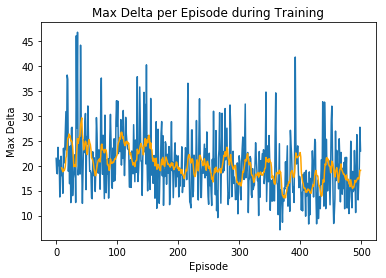

In [10]:
# max delta of each episode, where delta is the change in Q values
plt.plot(delta_list)
plt.title('Max Delta per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Max Delta')

# plot moving average
delta_frame = pd.DataFrame(delta_list)
rolling_mean = delta_frame.rolling(window=10).mean()
plt.plot(rolling_mean, label='Moving Average', color='orange')

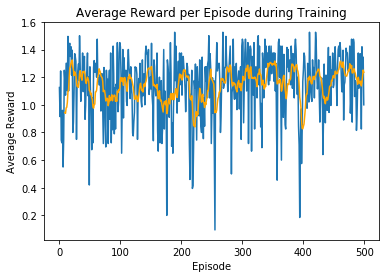

In [11]:
# average reward per episode
plt.plot(average_reward_list)
plt.title('Average Reward per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Average Reward')

# plot moving average
reward_frame = pd.DataFrame(average_reward_list)
rolling_mean = reward_frame.rolling(window=10).mean()
plt.plot(rolling_mean, label='Moving Average', color='orange')

Text(0, 0.5, 'Cumulative Reward')

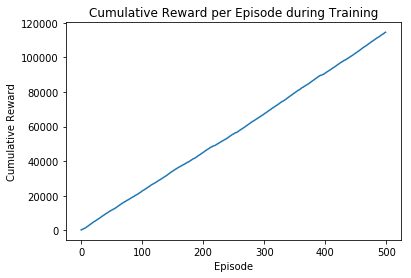

In [12]:
# cumulative reward per episode
plt.plot(cumulative_reward_list)
plt.title('Cumulative Reward per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')

In [13]:
np.set_printoptions(precision=2)
z_values

array([[0.  , 0.  , 0.  , 0.  ],
       [0.89, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.68, 7.6 , 6.35],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.89, 0.  , 0.  , 0.  ],
       [0.  , 5.28, 0.  , 0.89],
       [8.07, 4.53, 1.68, 5.6 ],
       [0.  , 0.  , 0.89, 4.08],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.89, 0.  , 0.  ],
       [0.  , 2.39, 0.  , 0.  ],
       [8.11, 0.  , 6.55, 0.89],
       [0.  , 0.  , 0.  , 0.89],
       [0.  , 0.  , 0.  , 0.  ],
       [0.89, 0.  , 0.  , 0.  ],
       [0.89, 1.68, 0.  , 0.  ],
       [6.55, 0.  , 0.  , 2.39],
       [0.  , 0.  , 0.  , 0.89],
       [0.  , 0.  , 0.  , 0.  ],
       [0.89, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.89, 0.  , 0.  , 0.  ]])

In [14]:
np.set_printoptions(precision=2)
Q_values

array([[-4.51e-03,  5.94e+00,  0.00e+00,  0.00e+00],
       [ 5.34e+01,  8.69e+00,  1.22e+01,  1.10e+01],
       [ 1.93e+01,  6.81e+01,  2.36e+01,  2.27e+01],
       [ 6.33e+01,  6.73e+01,  6.97e+01,  6.96e+01],
       [ 8.03e+00,  1.35e+01,  1.54e+01,  6.85e+01],
       [-5.06e-02,  2.20e+01,  0.00e+00,  0.00e+00],
       [ 4.36e+01,  9.25e+00,  1.05e+01,  4.34e+00],
       [ 4.99e+01,  6.93e+01,  5.41e+01,  3.59e+01],
       [ 7.65e+01,  6.15e+01,  6.28e+01,  6.00e+01],
       [ 5.74e+01,  5.82e+01,  5.82e+01,  6.60e+01],
       [ 1.13e+01,  0.00e+00,  0.00e+00, -1.73e-01],
       [ 1.56e+01,  5.91e+01,  2.50e+01,  4.65e+00],
       [ 4.94e+01,  6.57e+01,  5.21e+01,  4.51e+01],
       [ 5.06e+01,  5.79e+01,  5.78e+01,  5.73e+01],
       [ 5.62e+01,  5.52e+01,  5.60e+01,  6.42e+01],
       [-1.87e-02,  1.71e+01,  0.00e+00, -1.00e-01],
       [ 5.64e+01,  1.54e+01,  5.54e+00,  2.10e+00],
       [ 3.70e+01,  6.41e+01,  1.23e+01,  2.97e+01],
       [ 5.75e+01,  5.49e+01,  4.97e+01,  5.51

## Visualize Final Policy

In [15]:
# PRINT POLICY TABLE ################################################################################
# define column and index
columns=range(grid.size)
index = range(grid.size)
# define dataframe to represent policy table
policy_table = pd.DataFrame(index = index, columns=columns)

# iterate through policy to make a table that represents action number
# as action name (eg. left, right, up, down)
for state in range(len(Q_values)):
    
    # find the best action at each state
    best_action = np.argmax(Q_values[state])

    # get action name
    if best_action == 0:
        action_name = 'up'
    elif best_action == 1:
        action_name = 'right'
    elif best_action == 2:
        action_name = 'down'
    else:
        action_name = 'left'

    # calculate the row and column coordinate of the current state number
    row = int(state/grid.size)
    column = round((state/grid.size - int(state/grid.size))*grid.size)
            
    # assign action name
    policy_table.loc[row][column] = action_name

print("Policy Table: ")
print(policy_table)
print()

Policy Table: 
       0      1      2      3     4
0  right     up  right   down  left
1  right     up  right     up  left
2     up  right  right  right  left
3  right     up  right     up  left
4     up     up  right     up    up

